# Emission Measure
In this notebook, we'll generate the emission measure slope maps for each of our heating cases and save them as FITS files.

In [1]:
import os
import sys
import glob
import copy
import warnings

import numpy as np
from scipy.interpolate import splev
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.map import Map
import distributed

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.analysis import DistributedAIACollection,DistributedAIACube
from synthesizAR.analysis.dem import EMCube

sys.path.append('../scripts/')
from dem import HannahKontarModel, make_slope_map_tpeak

sys.path.append('../paper/python/')
from formatting import plot_hist,heating_palette

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [ ]:
def plot_hist2(ax, vals, bins, **kwargs):
    """
    Plot a histogram from bin values

    Parameters
    ----------
    ax : Matplotlib axis
    vals : value in each bin
    bins : Bin edges, including the rightmost edge
    kwargs : Plotting keyword arguments
    """
    ymin = ax.get_ylim()[0]
    ax.step(bins[:-1], vals, where='post', **kwargs)
    if 'label' in kwargs:
        del kwargs['label']
    ax.step(bins[-2:], [vals[-1], vals[-1]], where='pre', **kwargs)
    if 'marker' in kwargs:
        del kwargs['marker']
    ax.vlines(bins[0], ymin, vals[0], **kwargs)
    ax.vlines(bins[-1], ymin, vals[-1], **kwargs)

In [15]:
def make_slope_map(emcube, temperature_lower_bound=None, em_threshold=None):
    """
    Fit emission measure distribution in every pixel
    
    The fit is computed between `temperature_lower_bound`
    and the temeperature at which the EM is maximum.
    
    Parameters
    ----------
    emcube: `EMCube`
        Emission measure map as a function space and temperature
    em_threshold: `~astropy.units.Quantity`, optional
        If the total EM in a pixel is below this, no slope is calculated
        
    Returns
    -------
    slope_map: `~sunpy.map.GenericMap`
    rsquared_map: `~sunpy.map.GenericMap`
    """
    if em_threshold is None:
        em_threshold = u.Quantity(1e25, u.cm**(-5))
    i_valid = np.where(u.Quantity(emcube.total_emission.data, emcube[0].meta['bunit']) > em_threshold)
    em_valid = np.log10(emcube.as_array()[i_valid])
    em_valid[np.logical_or(np.isinf(em_valid), np.isnan(em_valid))] = 0.0
    i_peak = em_valid.argmax(axis=1)
    log_temperature_bin_centers = np.log10(emcube.temperature_bin_centers.value)
    if temperature_lower_bound is None:
        i_lower = 0
    else:
        i_lower = np.fabs(emcube.temperature_bin_centers - temperature_lower_bound).argmin()
    slopes,rsquared = [],[]
    for emv,ip in zip(em_valid,i_peak):
        t_fit = log_temperature_bin_centers[i_lower:ip]
        if t_fit.size < 3:
            warnings.warn('Fit should be over 3 or more bins in temperature.')
        if t_fit.size == 0:
            slopes.append(np.nan)
            rsquared.append(0.)
            continue
        em_fit = emv[i_lower:ip]
        w = np.where(em_fit>0, 1, 0)
        coeff,rss,_,_,_ = np.polyfit(t_fit, em_fit, 1, full=True, w=w)
        rss = 1 if rss.size == 0 else rss[0]
        _,rss_flat,_,_,_ = np.polyfit(t_fit, em_fit, 0, full=True, w=w)
        rss_flat = 1 if rss_flat.size == 0 else rss_flat[0]
        slopes.append(coeff[0])
        rsquared.append(1-rss/rss_flat)
    slopes_data = np.zeros(emcube.total_emission.data.shape)
    slopes_data[i_valid] = slopes
    rsquared_data = np.zeros(emcube.total_emission.data.shape)
    rsquared_data[i_valid] = rsquared
    
    return Map(slopes_data, emcube[0].meta,), Map(rsquared_data, emcube[0].meta)

In [2]:
cluster = distributed.LocalCluster(n_workers=32,threads_per_worker=2)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41612 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 32 Cores: 64 Memory: 270.38 GB


First, read in the model and observational data. For now, we'll just take a time-average. It may be better to time-average in chunks though still not completely sure about that...

In [3]:
intensity_file_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}/nei/SDO_AIA/{}/map_t{:06d}.fits'

Next, set up the temperature bins.

In [4]:
temperature_bin_edges = 10.**np.arange(5.5,7.3,0.1) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.

And calculate the instrument responses.

In [5]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [6]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

Now, we'll go through each heating case and compute the emission measure distribution.

### High

In [7]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(
    [intensity_file_format.format('high_frequency', c['name'], i) for i in range(500,2500)]) for c in aia.channels])

In [8]:
maps = [cube[c['name']].average() for c in aia.channels]

In [9]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl')

In [10]:
em_high = hk_model.fit(
    alpha=1,
    increase_alpha=1.1,
    verbose=False,
    n_sample=len(cube[0].maps)
)

In [11]:
del em_high[0].meta['keycomments']
em_high.save('../paper/data/high_frequency/em_cube.h5')

In [13]:
Tmax_high = Map(
    em_high.temperature_bin_centers[em_high.as_array().argmax(axis=2)].to(u.MK).value,
    em_high[0].meta,
    mask=em_high.total_emission.data < 1e24
)

In [16]:
slope_map,rsquared_map = make_slope_map(
    em_high,
    em_threshold=1e24*(u.cm**(-5)),
    temperature_lower_bound=8e5*u.K,
)
#slope_map.save(emslope_file_format.format('high_frequency'),overwrite=True)
#rsquared_map.save(rsquared_file_format.format('high_frequency'),overwrite=True)

/storage-home/w/wtb2/anaconda3/envs/synthetic-observables/lib/python3.6/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in double_scalars


## Intermediate 

In [17]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(
    [intensity_file_format.format('intermediate_frequency', c['name'], i) for i in range(500,2500)]) for c in aia.channels])

In [18]:
maps = [cube[c['name']].average() for c in aia.channels]

In [19]:
hk_model = HannahKontarModel(
    maps,
    temperature_bin_edges,
    responses,
    dem_path='/storage-home/w/wtb2/codes/demreg/idl'
)

In [20]:
em_intermediate = hk_model.fit(
    alpha=1,
    increase_alpha=1.1,
    verbose=False,
    n_sample=len(cube[0].maps)
)

In [21]:
del em_intermediate[0].meta['keycomments']
em_intermediate.save('../paper/data/intermediate_frequency/em_cube.h5')

In [ ]:
Tmax_intermediate = Map(
    em_intermediate.temperature_bin_centers[em_intermediate.as_array().argmax(axis=2)].to(u.MK).value,
    em_intermediate[0].meta,
    mask=em_intermediate.total_emission.data < 1e24
)

In [ ]:
slope_map,rsquared_map = make_slope_map(
    em_intermediate,
    em_threshold=1e24*(u.cm**(-5)),
    temperature_lower_bound=8e5*u.K,
)
slope_map.save(emslope_file_format.format('intermediate_frequency'),overwrite=True)
rsquared_map.save(rsquared_file_format.format('intermediate_frequency'),overwrite=True)

## Low

In [22]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(
    [intensity_file_format.format('low_frequency', c['name'], i) for i in range(500,2500)]) for c in aia.channels])

In [23]:
maps = [cube[c['name']].average() for c in aia.channels]

In [24]:
hk_model = HannahKontarModel(
    maps,
    temperature_bin_edges,
    responses,
    dem_path='/storage-home/w/wtb2/codes/demreg/idl'
)

In [25]:
em_low = hk_model.fit(
    alpha=1,
    increase_alpha=1.1,
    verbose=False,
    n_sample=len(cube[0].maps)
)

In [26]:
del em_low[0].meta['keycomments']
em_low.save('../paper/data/low_frequency/em_cube.h5')

In [ ]:
Tmax_low = Map(
    em_low.temperature_bin_centers[em_low.as_array().argmax(axis=2)].to(u.MK).value,
    em_low[0].meta,
    mask=em_low.total_emission.data < 1e24
)

In [ ]:
slope_map,rsquared_map = make_slope_map(
    em_low,
    em_threshold=1e24*(u.cm**(-5)),
    temperature_lower_bound=8e5*u.K,
)
slope_map.save(emslope_file_format.format('low_frequency'),overwrite=True)
rsquared_map.save(rsquared_file_format.format('low_frequency'),overwrite=True)

## Comparing 1D EM Distributions
Compare $\mathrm{EM}(T)$ across all three heating frequencies for a pixel-averaged 1D distribution

In [50]:
em_high[0].observer_coordinate.frame

<HeliographicStonyhurst Coordinate (obstime=2011-02-12 15:32:42): (lon, lat, radius) in (deg, deg, m)
    (0., -6.691409, 1.47657723e+11)>

In [27]:
TxTy = [dict(Tx=-275*u.arcsec,Ty=-195*u.arcsec),
        dict(Tx=-320*u.arcsec,Ty=-260*u.arcsec),
        dict(Tx=-300*u.arcsec,Ty=-300*u.arcsec)]
markers = ['o', 's', '^']

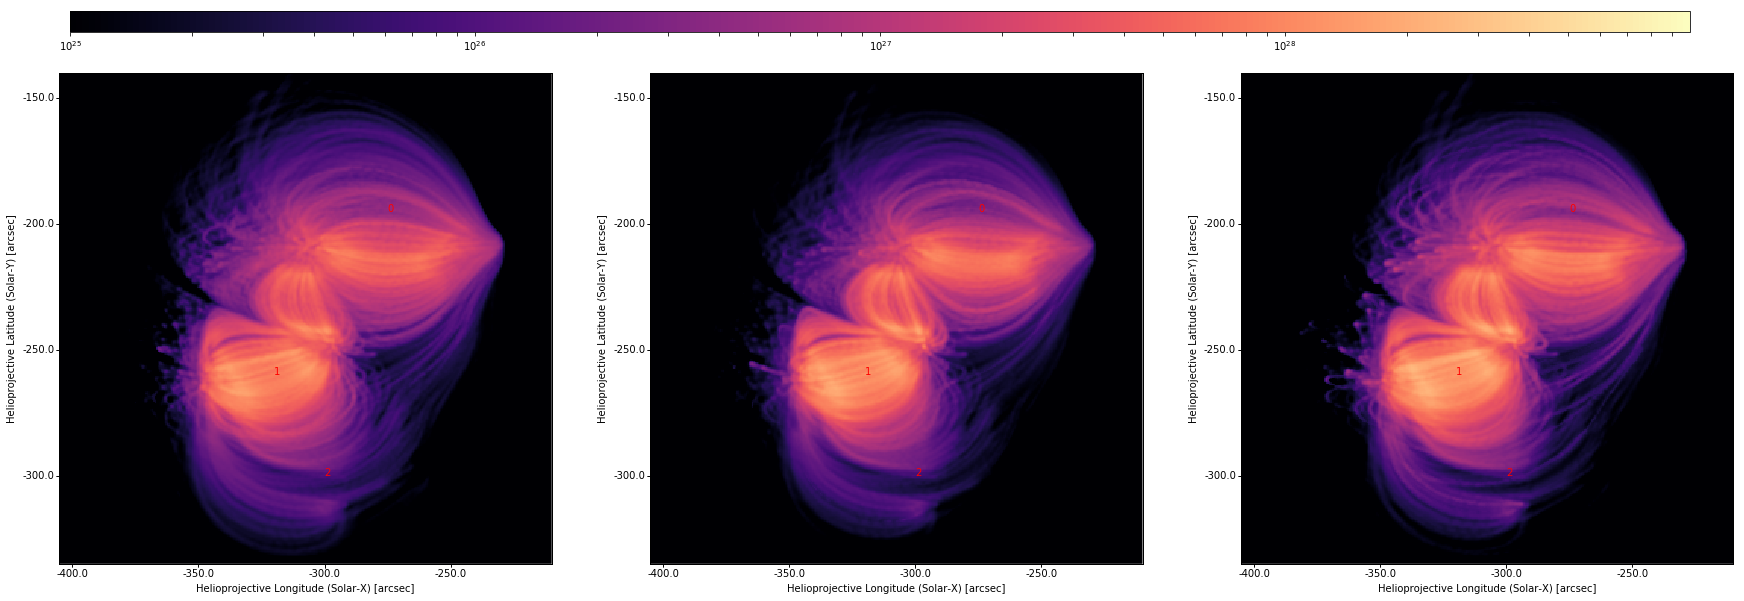

In [42]:
fig = plt.figure(figsize=(30,10))
for i,tm in enumerate([em_high.total_emission,em_intermediate.total_emission,em_low.total_emission]):
    tm = tm.submap(
        SkyCoord(Tx=-405*u.arcsec,Ty=-335*u.arcsec,frame=tm.coordinate_frame),
        SkyCoord(Tx=-210*u.arcsec,Ty=-140*u.arcsec,frame=tm.coordinate_frame),
    )
    ax = fig.add_subplot(1,3,i+1,projection=tm)
    im = tm.plot(axes=ax,title=False,cmap='magma', norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29))
    #tm.draw_rectangle(
    #    SkyCoord(Tx=-300*u.arcsec,Ty=-250*u.arcsec,frame=tm.coordinate_frame),
    #    1*u.arcsec, 1*u.arcsec, axes=ax, color='k'
    #)
    transform = ax.get_transform('world')
    for j,(m,p) in enumerate(zip(markers,TxTy)):
        ax.text(p['Tx'].to(u.deg).value,p['Ty'].to(u.deg).value,j,transform=transform,color='r',fontsize=plt.rcParams['axes.labelsize'])
    ax.grid(alpha=0)
cax = fig.add_axes((0.13,0.9,0.75,0.03))
cbar = fig.colorbar(im,cax=cax,orientation='horizontal')

In [44]:
em_high[0].scale.axis1

<Quantity 0.600698 arcsec / pix>

In [45]:
em_high.temperature_bin_edges

<Quantity [  316227.76601684,   398107.1705535 ,   501187.23362727,
             630957.34448019,   794328.23472428,  1000000.        ,
            1258925.41179416,  1584893.1924611 ,  1995262.31496887,
            2511886.43150956,  3162277.66016835,  3981071.70553494,
            5011872.33627267,  6309573.44480187,  7943282.34724272,
            9999999.99999988, 12589254.11794151, 15848931.92461091] K>

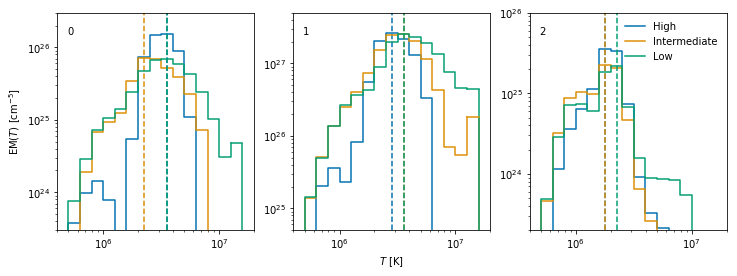

In [47]:
fig,axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=False)
labels = ['High', 'Intermediate', 'Low']

for i,_em in enumerate([em_high, em_intermediate, em_low]):
    # Calculate 1D EM
    for j,p in enumerate(TxTy):
        pos = SkyCoord(**p, frame=_em[0].coordinate_frame)
        em1d = _em.get_1d_distribution(
            pos,
            SkyCoord(Tx=pos.Tx+1*u.pixel*_em[0].scale.axis1, Ty=pos.Ty+1*u.pixel*_em[0].scale.axis2, frame=_em[0].coordinate_frame)
        )
        plot_hist(axes[j], em1d.value, temperature_bin_edges.value, color=heating_palette()[i], label=labels[i])
        axes[j].axvline(temperature_bin_centers[em1d.argmax()].to(u.K).value, color=heating_palette()[i], ls='--')
        axes[j].set_yscale('log')
        
        # Calculate slope
        #index_temperature_bounds = np.where(np.logical_and(
        #    temperature_bin_centers >= temperature_bin_centers[np.argmax(em1d)-3],
        #    temperature_bin_centers <= temperature_bin_centers[np.argmax(em1d)]))
        #temperature_fit = np.log10(
        #    temperature_bin_centers[index_temperature_bounds].to(u.K).value)
        #em_fit = np.log10(em1d[index_temperature_bounds].value)
        #em_fit[np.logical_or(np.isinf(em_fit), np.isnan(em_fit))] = 0.0 
        #coeff,rss,_,_,_ = np.polyfit(temperature_fit, em_fit, 1,full=True,w=np.where(em_fit>0,1,0))
        #_,rss_flat,_,_,_ = np.polyfit(temperature_fit, em_fit, 0,full=True,w=np.where(em_fit>0,1,0))

        # Plot symbol corresponding to location noted previously
        if i == 0:
            axes[j].text(0.05,0.9,j,transform=axes[j].transAxes, color='k', fontsize=plt.rcParams['axes.labelsize'])

#ax.plot(10**temperature_fit,(10**coeff[1])*(10**temperature_fit)**coeff[0],color='r')
# Labels
axes[0].set_ylabel(r'$\mathrm{EM}(T)$ [cm$^{-5}$]')
axes[1].set_xlabel(r'$T$ [K]')
# Limits and scale
axes[0].set_xscale('log')
axes[0].set_xlim(4*10**5,2*10**7)
axes[0].set_ylim(3e23,3e26)
axes[1].set_ylim(5e24,5e27)
axes[2].set_ylim(2e23,1e26)
axes[2].legend(loc=1,frameon=False)
plt.subplots_adjust(hspace=0.05)